#Importing Dataset

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Project/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d mehradaria/leukemia --force

100% 110M/110M [00:05<00:00, 31.0MB/s]
100% 110M/110M [00:05<00:00, 20.8MB/s]


In [ ]:
from zipfile import ZipFile

dataset = '/content/leukemia.zip'

with ZipFile(dataset, 'r') as zip:
    for file in zip.namelist():
        if 'Segmented' in file:
            zip.extract(file)
    print('The segmented dataset is extracted')

The segmented dataset is extracted


In [ ]:
!ls

drive  leukemia.zip  sample_data  Segmented


#Importing Dependencies

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#Preprocessing

In [ ]:
folder_path = '/content/Segmented'

subfolders = [f for f in os.listdir(folder_path) if
              os.path.isdir(os.path.join(folder_path, f))]

# Display the subfolder names
for subfolder in subfolders:
    os.makedirs('/content/train/'+subfolder)
    os.makedirs('/content/test/'+subfolder)

In [ ]:
import os
import shutil

for subfolder in subfolders:
    source_folder = ('/content/Segmented/'+subfolder)
    destination_train = ('/content/train/'+subfolder)
    destination_test = ('/content/test/'+subfolder)
    split_ratio = 0.8  # Split ratio, e.g., 0.8 for 80% training and 20% testing

    # Get the list of files in the source folder
    files = os.listdir(source_folder)

    # Calculate the number of files to split based on the split ratio
    num_files = len(files)
    split_index = int(num_files * split_ratio)

    # Split the files into training and testing
    training_files = files[:split_index]
    testing_files = files[split_index:]

    # Move the training files to the destination folder
    for file in training_files:
        source_file = os.path.join(source_folder, file)
        destination_file = os.path.join(destination_train, file)
        shutil.move(source_file, destination_file)

    # Move the testing files to the destination folder
    for file in testing_files:
        source_file = os.path.join(source_folder, file)
        destination_file = os.path.join(destination_test, file)
        shutil.move(source_file, destination_file)


In [ ]:
base_dir = '/content'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# Directory with our training Original pictures
train_benign_dir = os.path.join(train_dir, 'Benign')
train_early_dir = os.path.join(train_dir, 'Early')
train_pre_dir = os.path.join(train_dir, 'Pre')
train_pro_dir = os.path.join(train_dir, 'Pro')

# Directory with our validation Original pictures
validation_benign_dir = os.path.join(validation_dir, 'Benign')
validation_early_dir = os.path.join(validation_dir, 'Early')
validation_pre_dir = os.path.join(validation_dir, 'Pre')
validation_pro_dir = os.path.join(validation_dir, 'Pro')

In [ ]:
print('total training benign images :', len(os.listdir(train_benign_dir)))
print('total training early images :', len(os.listdir(train_early_dir)))
print('total training pre images :', len(os.listdir(train_pre_dir)))
print('total training pro images :', len(os.listdir(train_pro_dir)))

print('total validation benign images :', len(os.listdir(validation_benign_dir)))
print('total validation early images :', len(os.listdir(validation_early_dir )))
print('total validation pre images :', len(os.listdir(validation_pre_dir)))
print('total validation pro images :', len(os.listdir(validation_pro_dir )))

total training benign images : 403
total training early images : 788
total training pre images : 770
total training pro images : 643
total validation benign images : 101
total validation early images : 197
total validation pre images : 193
total validation pro images : 161


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "tmp/rps-test/rps-test-set"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	validation_dir,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

Found 2604 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


#Building the Model

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 60 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('accuracy') > 0.99) and (logs.get('val_accuracy')>0.99):

      # Stop if threshold is met
      # 99.9% nggak bisa, 99%/98% udh konvergen sampe epoch 330an. max 99,48??
      print("\nAccuracy is higher than 99% so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [ ]:
# # Train the model
history = model.fit(train_generator, epochs=350, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, callbacks=[callbacks])

Epoch 1/350
20/20 [==============================] - 36s 1s/step - loss: 1.2449 - accuracy: 0.4314 - val_loss: 0.8257 - val_accuracy: 0.6258
Epoch 2/350
20/20 [==============================] - 19s 956ms/step - loss: 0.8263 - accuracy: 0.6533 - val_loss: 0.5965 - val_accuracy: 0.7669
Epoch 3/350
20/20 [==============================] - 21s 1s/step - loss: 0.7371 - accuracy: 0.6956 - val_loss: 0.5991 - val_accuracy: 0.7699
Epoch 4/350
20/20 [==============================] - 20s 1s/step - loss: 0.7137 - accuracy: 0.7090 - val_loss: 0.5716 - val_accuracy: 0.7791
Epoch 5/350
20/20 [==============================] - 22s 1s/step - loss: 0.6233 - accuracy: 0.7538 - val_loss: 0.5241 - val_accuracy: 0.7837
Epoch 6/350
20/20 [==============================] - 19s 958ms/step - loss: 0.6349 - accuracy: 0.7361 - val_loss: 0.5016 - val_accuracy: 0.7945
Epoch 7/350
20/20 [==============================] - 20s 1s/step - loss: 0.6474 - accuracy: 0.7401 - val_loss: 0.5640 - val_accuracy: 0.7791
Epoch 8

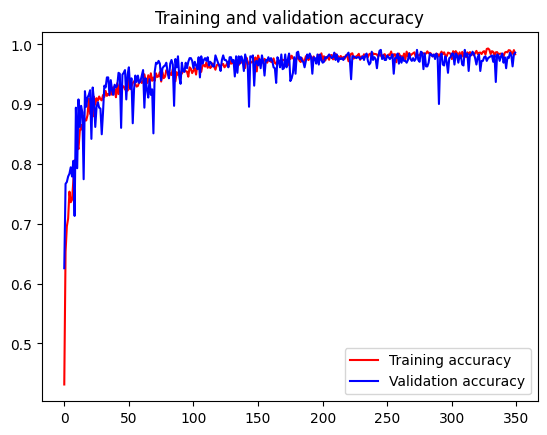

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

#Saving the Model

In [ ]:
saved_model_path = "/content/my_model.h5"
model.save(saved_model_path)

#Class Prediction on Uploaded Images

In [ ]:
def input_samples (TEST):
    test_img = tf.keras.preprocessing.image.load_img(TEST, target_size=(150,150))
    x = tf.keras.preprocessing.image.img_to_array(test_img)
    x = np.expand_dims(x, axis=0)
    x = x/255
    images = np.vstack([x])
    return images

In [ ]:
from google.colab import files
import os
import cv2
categories = ['Benign', 'Early', 'Pre', 'Pro']
uploaded = files.upload()
for fn in uploaded.keys():
  Test_org = f'./{fn}'
  light_orange = (168, 50, 50)
  dark_orange = (182, 255, 255)
  image = cv2.imread(Test_org)
  image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
  mask = cv2.inRange(image, light_orange, dark_orange)
  result = cv2.bitwise_and(image, image, mask=mask)
  result = cv2.resize(result, (150,150))
  image_name = Test_org.split(sep='/')[-1]
  Test_org = f'./Seg-{image_name}'
  cv2.imwrite(Test_org, result)
  Test_org = input_samples(Test_org)
  classes = model.predict(Test_org,batch_size=20)
  print(classes)
  classes = np.argmax(classes,axis=1)
  print ('Class:', categories[int(classes)])

Saving Acute_leukemia-ALL.jpg to Acute_leukemia-ALL.jpg
1/1 [==============================] - 0s 419ms/step
[[3.3645192e-04 3.7325288e-03 4.5749363e-03 9.9135602e-01]]
Class: Pro
